In [ ]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import math
import pandas as pd

In [ ]:
def build_P(K=3, rho=0.2):
    """
    Build K x K matrix P with diag=1 and P_{kl} = rho^{|k-l|} for k != l.
    """
    P = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            if k == l:
                P[k, l] = 1.0
            else:
                P[k, l] = rho ** abs(k - l)
    return P

def build_memberships(n=3000, n0=500):
    """
    Build membership matrix Π (n x 3) exactly as in Model 1.

    - First n0 nodes: pure community 1 (1,0,0)
    - Next n0: pure community 2 (0,1,0)
    - Next n0: pure community 3 (0,0,1)
    - Remaining nodes split into 4 equal groups with memberships a1,...,a4.
    """
    K = 3
    Pi = np.zeros((n, K))

    # Check sizes
    assert 3 * n0 <= n, "n0 too large for given n."
    rem = n - 3 * n0
    assert rem % 4 == 0, "Remaining nodes must be divisible by 4."

    # Pure nodes
    Pi[0:n0, :]          = np.array([1, 0, 0])  # comm 1
    Pi[n0:2*n0, :]       = np.array([0, 1, 0])  # comm 2
    Pi[2*n0:3*n0, :]     = np.array([0, 0, 1])  # comm 3

    # Mixed memberships a1,...,a4
    a1 = np.array([0.2, 0.6, 0.2])
    a2 = np.array([0.6, 0.2, 0.2])
    a3 = np.array([0.2, 0.2, 0.6])
    a4 = np.array([1/3, 1/3, 1/3])

    m = rem // 4
    start = 3 * n0

    Pi[start:start + m, :]         = a1
    Pi[start + m:start + 2*m, :]   = a2
    Pi[start + 2*m:start + 3*m, :] = a3
    Pi[start + 3*m:start + 4*m, :] = a4

    return Pi


In [2]:
def simulate_model1(n=3000, n0=500, rho=0.2, theta=0.5, seed=None):
    """
    Simulate adjacency matrix X under Model 1.
    """
    if seed is not None:
        np.random.seed(seed)

    K = 3
    P = build_P(K=K, rho=rho)
    Pi = build_memberships(n=n, n0=n0)

    # Mean probability matrix H = theta * Π P Π^T
    H = theta * Pi @ P @ Pi.T

    # Clip to [0,1] just in case
    H = np.clip(H, 0.0, 1.0)

    # Sample Bernoulli edges
    X = np.random.binomial(1, H)
    X = np.triu(X, 1)
    X = X + X.T
    np.fill_diagonal(X, 0)

    return X, Pi, P


In [3]:
def sample_theta_dcmm(n, r=0.5, seed=None):
    """
    Sample degree parameters θ_i with 1/θ_i ~ Uniform[1/r, 2/r].
    """
    if seed is not None:
        np.random.seed(seed)

    u = np.random.uniform(low=1/r, high=2/r, size=n)
    theta = 1.0 / u
    return theta

def simulate_model2(n=3000, n0=500, rho=0.2, r=0.5, seed=None):
    """
    Simulate adjacency matrix X under Model 2 (DCMM).
    """
    if seed is not None:
        np.random.seed(seed)

    K = 3
    P = build_P(K=K, rho=rho)
    Pi = build_memberships(n=n, n0=n0)

    theta = sample_theta_dcmm(n=n, r=r)
    Theta = np.diag(theta)

    H = Theta @ Pi @ P @ Pi.T @ Theta
    H = np.clip(H, 0.0, 1.0)

    X = np.random.binomial(1, H)
    X = np.triu(X, 1)
    X = X + X.T
    np.fill_diagonal(X, 0)

    return X, Pi, P, theta


In [4]:
def indices_for_a1_group(n, n0):
    rem = n - 3 * n0
    m = rem // 4
    start = 3 * n0
    end = start + m
    return np.arange(start, end)  # all nodes with π = a1

def indices_for_pure_comm2(n0):
    return np.arange(n0, 2 * n0)  # nodes with π = (0,1,0)


In [5]:
def choose_pair_indices(n, n0, for_null=True, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    a1_idx = indices_for_a1_group(n, n0)
    pure2_idx = indices_for_pure_comm2(n0)

    if for_null:
        # both from a1 group (same membership)
        i, j = rng.choice(a1_idx, size=2, replace=False)
    else:
        # i from a1, j from pure comm 2 (different membership)
        i = rng.choice(a1_idx)
        j = rng.choice(pure2_idx)
    return int(i), int(j)


In [2]:
pip install scipy

   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.5 MB 13.1 MB/s eta 0:00:03
   ----- ---------------------------------- 5.2/38.5 MB 13.5 MB/s eta 0:00:03
   ---------- ----------------------------- 10.0/38.5 MB 17.3 MB/s eta 0:00:02
   --------------- ------------------------ 14.9/38.5 MB 19.1 MB/s eta 0:00:02
   -------------------- ------------------- 19.7/38.5 MB 19.6 MB/s eta 0:00:01
   ------------------------- -------------- 24.6/38.5 MB 20.2 MB/s eta 0:00:01
   ------------------------------ --------- 29.4/38.5 MB 20.8 MB/s eta 0:00:01
   ---------------------------------- ----- 32.8/38.5 MB 20.8 MB/s eta 0:00:01
   ---------------------------------------  38.3/38.5 MB 20.8 MB/s eta 0:00:01
   ---------------------------------------- 38.5/38.5 MB 20.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# --------------------------------------------------
# Spectral helpers
# --------------------------------------------------

def _spectral_decomp_topK(X, K):
    """
    Compute top-K eigenpairs of symmetric matrix X, ordered by |eigenvalue| descending.
    """
    w, V = np.linalg.eigh(X)
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    d_hat = w[idx_top]
    V_hat = V[:, idx_top]
    return d_hat, V_hat

def _row_variances_from_spectral(V_hat, d_hat, t):
    """
    Approximate row t of H = V_hat diag(d_hat) V_hat^T,
    then variance row sigma^2_tl = h_tl (1 - h_tl).
    """
    temp = V_hat[t, :] * d_hat
    h_row = temp @ V_hat.T
    h_row = np.clip(h_row, 1e-6, 1 - 1e-6)
    var_row = h_row * (1.0 - h_row)
    return var_row

def _sigma1_hat_for_pair(V_hat, d_hat, i, j):
    """
    Plug-in estimator for Σ1 for a given pair (i,j).
    """
    n, K = V_hat.shape
    Sigma = np.zeros((K, K))

    var_i = _row_variances_from_spectral(V_hat, d_hat, i)
    var_j = _row_variances_from_spectral(V_hat, d_hat, j)

    h_ij = float(np.dot(V_hat[i, :] * d_hat, V_hat[j, :]))
    h_ij = float(np.clip(h_ij, 1e-6, 1 - 1e-6))
    sigma_ij2 = h_ij * (1.0 - h_ij)

    for a in range(K):
        va = V_hat[:, a]
        for b in range(K):
            vb = V_hat[:, b]
            prod = va * vb
            sum_term = np.dot(var_i, prod) + np.dot(var_j, prod)
            correction = sigma_ij2 * (va[j] * vb[i] + va[i] * vb[j])
            Sigma[a, b] = (sum_term - correction) / (d_hat[a] * d_hat[b])

    return Sigma









In [7]:
# --------------------------------------------------
# SIMPLE T_ij
# --------------------------------------------------

def simple_Tij(X, i, j, K, ridge=1e-6, use_pinv=False):
    """
    SIMPLE test statistic T_ij for mixed membership model (Model 1).
    """
    n = X.shape[0]
    assert 0 <= i < n and 0 <= j < n and i != j

    d_hat, V_hat = _spectral_decomp_topK(X, K)
    Sigma1_hat = _sigma1_hat_for_pair(V_hat, d_hat, i, j)
    Sigma1_reg = Sigma1_hat + ridge * np.eye(K)

    if use_pinv:
        Sigma1_inv = np.linalg.pinv(Sigma1_reg)
    else:
        Sigma1_inv = np.linalg.inv(Sigma1_reg)

    diff = V_hat[i, :] - V_hat[j, :]
    T_ij = float(diff @ Sigma1_inv @ diff)
    return T_ij


In [8]:
def simulate_size_power_model1(n, n0, rho, theta_values, K=3,
                               n_rep=500, alpha=0.05, seed=None):
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    results = {
        "theta": [],
        "size": [],
        "power": []
    }

    crit = chi2.ppf(1 - alpha, df=K)

    for theta in theta_values:
        rejections_null = 0
        rejections_alt = 0

        for rep in range(n_rep):
            # Simulate network
            X, Pi, P = simulate_model1(
                n=n, n0=n0, rho=rho,
                theta=theta,
                seed=rng.integers(1e9)
            )

            # --- size (null) ---
            i_null, j_null = choose_pair_indices(n, n0, for_null=True, rng=rng)
            T_null = simple_Tij(X, i_null, j_null, K)
            if T_null > crit:
                rejections_null += 1

            # --- power (alternative) ---
            i_alt, j_alt = choose_pair_indices(n, n0, for_null=False, rng=rng)
            T_alt = simple_Tij(X, i_alt, j_alt, K)
            if T_alt > crit:
                rejections_alt += 1

        size_est = rejections_null / n_rep
        power_est = rejections_alt / n_rep

        results["theta"].append(theta)
        results["size"].append(size_est)
        results["power"].append(power_est)

        print(f"[Model1] θ={theta:.1f}  size={size_est:.3f}  power={power_est:.3f}")

    return results


In [ ]:


theta_values = np.round(np.arange(0.2, 1.0, 0.1), 1)
res1_3000 = simulate_size_power_model1(
    n=3000, n0=500, rho=0.2,
    theta_values=theta_values, K=3,
    n_rep=100, alpha=0.05, seed=123
)

print(res1_3000)  # just to see the dict


[Model1] θ=0.2  size=0.070  power=0.850
[Model1] θ=0.3  size=0.030  power=0.990
[Model1] θ=0.4  size=0.030  power=1.000
[Model1] θ=0.5  size=0.010  power=1.000
[Model1] θ=0.6  size=0.010  power=1.000
[Model1] θ=0.7  size=0.000  power=1.000
[Model1] θ=0.8  size=0.000  power=1.000
[Model1] θ=0.9  size=0.010  power=1.000
{'theta': [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)], 'size': [0.07, 0.03, 0.03, 0.01, 0.01, 0.0, 0.0, 0.01], 'power': [0.85, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


In [ ]:

theta_values = np.round(np.arange(0.2, 1.0, 0.1), 1)
res1_1500 = simulate_size_power_model1(
    n=1500, n0=300, rho=0.2,
    theta_values=theta_values, K=3,
    n_rep=100, alpha=0.05, seed=123
)

print(res1_3000)  # just to see the dict


[Model1] θ=0.2  size=0.030  power=0.760
[Model1] θ=0.3  size=0.090  power=0.900
[Model1] θ=0.4  size=0.050  power=0.950
[Model1] θ=0.5  size=0.060  power=0.980
[Model1] θ=0.6  size=0.040  power=1.000
[Model1] θ=0.7  size=0.030  power=1.000
[Model1] θ=0.8  size=0.020  power=1.000
[Model1] θ=0.9  size=0.000  power=1.000
{'theta': [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)], 'size': [0.07, 0.03, 0.03, 0.01, 0.01, 0.0, 0.0, 0.01], 'power': [0.85, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


In [ ]:
def collect_null_T_stats_model1(n=3000, n0=500, rho=0.2,
                                K=3, n_rep=500, seed=123):
    """
    Collect T_ij values under the null (π_i = π_j = a1) for Model 1.
    Uses theta = 1 / (2 log n), as in the paper.
    """
    rng = np.random.default_rng(seed)
    theta = 1.0 / (2.0 * math.log(n))

    stats = []

    for rep in range(n_rep):
        # Simulate one network
        X, Pi, P = simulate_model1(
            n=n, n0=n0, rho=rho, theta=theta,
            seed=rng.integers(1e9)
        )

        # Pick a null pair (same membership a1)
        i, j = choose_pair_indices(n, n0, for_null=True, rng=rng)

        # Compute SIMPLE statistic
        T_ij = simple_Tij(X, i, j, K)
        stats.append(T_ij)

    return np.array(stats), theta

def plot_null_hist_vs_chi2(stats, K=3, n=None, theta=None, title_prefix="Model 1"):
    """
    Plot histogram of T_ij under null and overlay χ²_K density.
    """
    stats = np.asarray(stats)
    # nice x-range: up to 99th percentile
    xmax = np.percentile(stats, 99)
    x = np.linspace(0, xmax, 200)

    plt.figure(figsize=(6, 4))
    plt.hist(stats, bins=30, density=True, alpha=0.6, edgecolor="k")
    plt.plot(x, chi2.pdf(x, df=K), linewidth=2)

    label = rf"$\chi^2_{K}$ density"
    plt.legend(["Chi-square density", "Empirical T_ij"], loc="upper right")
    plt.xlabel(r"$\hat T_{ij}$")
    plt.ylabel("Density")

    if n is not None and theta is not None:
        plt.title(f"{title_prefix}: n={n}, θ≈{theta:.3f}")
    else:
        plt.title(f"{title_prefix}: null histogram vs χ²_{K}")

    plt.tight_layout()
    plt.show()


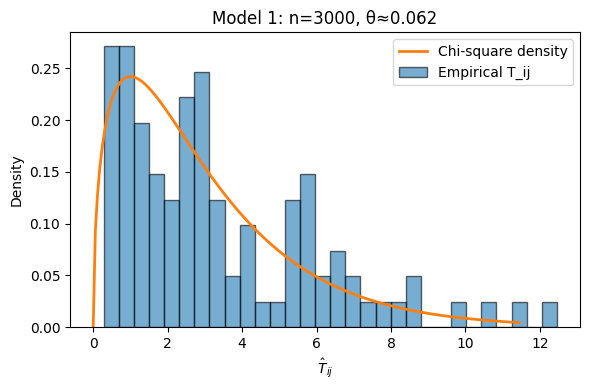

In [101]:
# Collect null stats
stats_3000, theta_3000 = collect_null_T_stats_model1(
    n=3000, n0=500, rho=0.2,
    K=3, n_rep=100, seed=123
)

# Plot
plot_null_hist_vs_chi2(
    stats_3000, K=3,
    n=3000, theta=theta_3000,
    title_prefix="Model 1"
)


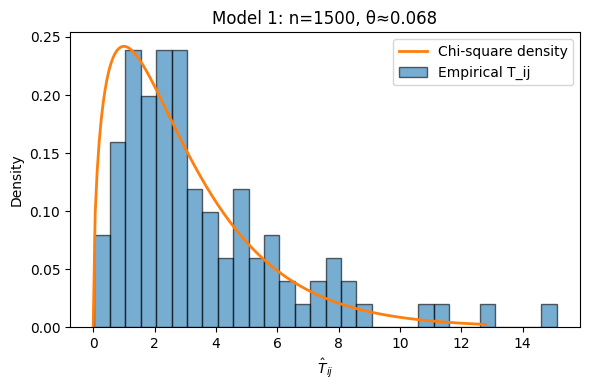

In [103]:
# Collect null stats
stats_1500, theta_1500 = collect_null_T_stats_model1(
    n=1500, n0=300, rho=0.2,
    K=3, n_rep=100, seed=123
)

# Plot
plot_null_hist_vs_chi2(
    stats_1500, K=3,
    n=1500, theta=theta_1500,
    title_prefix="Model 1"
)


In [ ]:


theta_values = np.round(np.arange(0.2, 1.0, 0.1), 1)
res1_3000 = simulate_size_power_model1(
    n=3000, n0=500, rho=0.2,
    theta_values=theta_values, K=3,
    n_rep=500, alpha=0.05, seed=123
)

print(res1_3000)  # just to see the dict


[Model1] θ=0.2  size=0.046  power=0.896
[Model1] θ=0.3  size=0.022  power=0.982
[Model1] θ=0.4  size=0.022  power=1.000
[Model1] θ=0.5  size=0.016  power=1.000
[Model1] θ=0.6  size=0.004  power=1.000
[Model1] θ=0.7  size=0.010  power=1.000
[Model1] θ=0.8  size=0.008  power=1.000
[Model1] θ=0.9  size=0.004  power=1.000
{'theta': [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)], 'size': [0.046, 0.022, 0.022, 0.016, 0.004, 0.01, 0.008, 0.004], 'power': [0.896, 0.982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


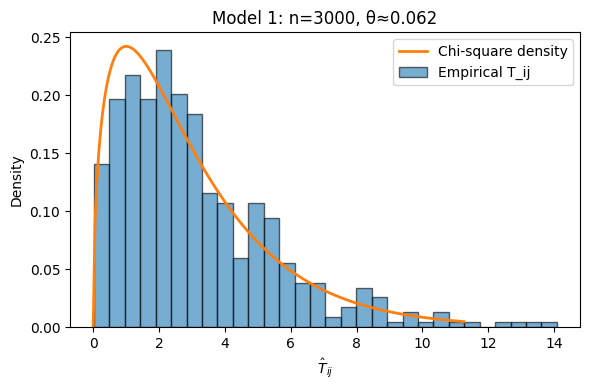

In [106]:
# Collect null stats
stats_3000, theta_3000 = collect_null_T_stats_model1(
    n=3000, n0=500, rho=0.2,
    K=3, n_rep=500, seed=123
)

# Plot
plot_null_hist_vs_chi2(
    stats_3000, K=3,
    n=3000, theta=theta_3000,
    title_prefix="Model 1"
)


In [ ]:


theta_values = np.round(np.arange(0.2, 1.0, 0.1), 1)
res1_1500 = simulate_size_power_model1(
    n=1500, n0=300, rho=0.2,
    theta_values=theta_values, K=3,
    n_rep=100, alpha=0.05, seed=123
)

print(res1_3000)  # just to see the dict


[Model1] θ=0.2  size=0.030  power=0.760
[Model1] θ=0.3  size=0.090  power=0.900
[Model1] θ=0.4  size=0.050  power=0.950
[Model1] θ=0.5  size=0.060  power=0.980
[Model1] θ=0.6  size=0.040  power=1.000
[Model1] θ=0.7  size=0.030  power=1.000
[Model1] θ=0.8  size=0.020  power=1.000
[Model1] θ=0.9  size=0.000  power=1.000
{'theta': [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)], 'size': [0.046, 0.022, 0.022, 0.016, 0.004, 0.01, 0.008, 0.004], 'power': [0.896, 0.982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


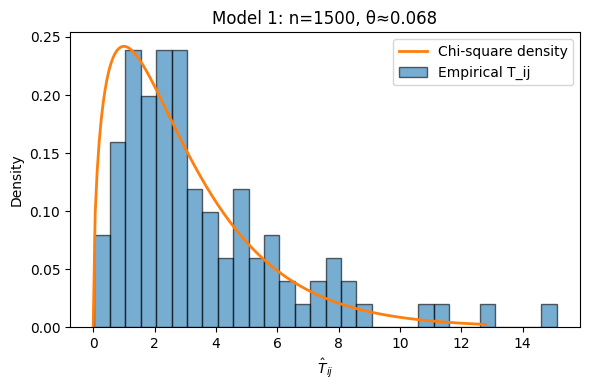

In [ ]:
# Collect null stats
stats_1500, theta_1500 = collect_null_T_stats_model1(
    n=1500, n0=300, rho=0.2,
    K=3, n_rep=500, seed=123
)

# Plot
plot_null_hist_vs_chi2(
    stats_1500, K=3,
    n=1500, theta=theta_1500,
    title_prefix="Model 1"
)


In [ ]:


# --------------------------------------------------
# 1. Memberships and helper indices (same layout as paper)
# --------------------------------------------------

def build_memberships(n=1500, n0=300):
    """
    Build Π (n x 3) as in the paper:
      - first n0 nodes: pure comm 1  -> (1,0,0)
      - next  n0 nodes: pure comm 2  -> (0,1,0)
      - next  n0 nodes: pure comm 3  -> (0,0,1)
      - remaining nodes split into 4 equal mixed groups with:
          a1 = (0.2, 0.6, 0.2)
          a2 = (0.6, 0.2, 0.2)
          a3 = (0.2, 0.2, 0.6)
          a4 = (1/3, 1/3, 1/3)
    """
    K = 3
    Pi = np.zeros((n, K))

    assert 3 * n0 <= n, "n0 too large for given n."
    rem = n - 3 * n0
    assert rem % 4 == 0, "n - 3*n0 must be divisible by 4."

    # pure nodes
    Pi[0:n0, :]      = np.array([1, 0, 0])
    Pi[n0:2*n0, :]   = np.array([0, 1, 0])
    Pi[2*n0:3*n0, :] = np.array([0, 0, 1])

    # mixed nodes
    a1 = np.array([0.2, 0.6, 0.2])
    a2 = np.array([0.6, 0.2, 0.2])
    a3 = np.array([0.2, 0.2, 0.6])
    a4 = np.array([1/3, 1/3, 1/3])

    m = rem // 4
    start = 3 * n0
    Pi[start:start+m, :]         = a1
    Pi[start+m:start+2*m, :]     = a2
    Pi[start+2*m:start+3*m, :]   = a3
    Pi[start+3*m:start+4*m, :]   = a4

    return Pi

def indices_for_a1_group(n, n0):
    """Indices of nodes with membership a1 = (0.2,0.6,0.2)."""
    rem = n - 3 * n0
    m = rem // 4
    start = 3 * n0
    end = start + m
    return np.arange(start, end)

def indices_for_pure_comm2(n0):
    """Indices of pure community 2 (e2 = (0,1,0))."""
    return np.arange(n0, 2*n0)

def choose_pair_indices(n, n0, for_null=True, rng=None):
    """
    for_null=True: i,j both from a1 group (null)
    for_null=False: i from a1, j from pure community 2 (alternative)
    """
    if rng is None:
        rng = np.random.default_rng()

    a1_idx = indices_for_a1_group(n, n0)
    pure2_idx = indices_for_pure_comm2(n0)

    if for_null:
        i, j = rng.choice(a1_idx, size=2, replace=False)
    else:
        i = rng.choice(a1_idx)
        j = rng.choice(pure2_idx)

    return int(i), int(j)








In [11]:
# --------------------------------------------------
# 2. P matrix and DCMM theta_i, Model 2 simulator
# --------------------------------------------------

def build_P_model2(rho=0.2):
    """
    Connectivity matrix used in the paper (same for Model 2).
    Diagonal = 1, off-diagonals = rho.
    """
    return np.array([
        [1.0, rho, rho],
        [rho, 1.0, rho],
        [rho, rho, 1.0]
    ])

def theta_dcmm(n, r):
    """
    Degree parameters for DCMM:
      1 / theta_i ~ Uniform(1/r, 2/r).
    """
    u = np.random.uniform(1/r, 2/r, size=n)
    theta = 1.0 / u
    return theta

def simulate_model2(n=1500, n0=300, rho=0.2, r=0.5, seed=None):
    """
    Model 2: X_ij ~ Bernoulli(theta_i * theta_j * π_i^T P π_j).
    """
    if seed is not None:
        np.random.seed(seed)

    Pi = build_memberships(n=n, n0=n0)
    P = build_P_model2(rho=rho)
    theta = theta_dcmm(n, r)

    H_core = Pi @ P @ Pi.T               # community structure
    H = np.outer(theta, theta) * H_core  # DCMM
    H = np.clip(H, 1e-6, 1 - 1e-6)

    X = np.random.binomial(1, H)
    X = np.triu(X, 1)
    X = X + X.T
    np.fill_diagonal(X, 0)

    return X, Pi, P, theta

In [ ]:
# --------------------------------------------------
# 3. Spectral + Y + Σ2 estimation + G_ij
# --------------------------------------------------

def _spectral_decomp_topK(X, K):
    w, V = np.linalg.eigh(X)
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    d_hat = w[idx_top]
    V_hat = V[:, idx_top]
    return d_hat, V_hat

def build_Y_from_V(V_hat):
    """
    Build Y (n x (K-1)) of ratio eigenvector features:
      Y_i(k-1) = v_k(i) / v_1(i), k=2,...,K.
    """
    n, K = V_hat.shape
    v1 = V_hat[:, 0]
    eps = 1e-8
    denom = np.where(np.abs(v1) > eps, v1, np.sign(v1) * eps + (v1 == 0)*eps)
    Y = V_hat[:, 1:] / denom[:, None]
    return Y

def estimate_Sigma2_null_only(Y, null_idx, ridge=1e-4):
    """
    Estimate Σ2 using ONLY null-group nodes (a1 group).
    """
    n, q = Y.shape
    F = np.sqrt(n) * Y[null_idx, :]   # scale so entries are O(1)
    S = np.cov(F.T, bias=False)       # q x q
    S += ridge * np.eye(q)
    S_inv = np.linalg.pinv(S)
    return S_inv

def simple_Gij_model2(i, j, Y, S2_inv):
    """
    SIMPLE G_ij for Model 2 using empirical Σ2 from null nodes.

      G_ij = (sqrt(n)Y_i - sqrt(n)Y_j)^T Σ2^{-1} (sqrt(n)Y_i - sqrt(n)Y_j)
    """
    n, q = Y.shape
    Fi = np.sqrt(n) * Y[i, :]
    Fj = np.sqrt(n) * Y[j, :]
    diff = Fi - Fj
    return float(diff @ S2_inv @ diff)

In [14]:
# --------------------------------------------------
# 4. Size & power simulation for Model 2 (Table 1 style)
# --------------------------------------------------

def simulate_size_power_model2(n, n0, rho, r2_values, K=3,
                               n_rep=500, alpha=0.05, seed=123):
    """
    Monte Carlo size and power for Model 2 (DCMM) using G_ij.

    - n, n0: sample size and pure-node count
    - rho: off-diagonal of P
    - r2_values: list/array of r^2 values (0.2, 0.3, ..., 0.9)
    - K: number of communities (3 in the paper)
    - n_rep: Monte Carlo repetitions per r^2
    - alpha: nominal significance level
    """
    rng = np.random.default_rng(seed)
    crit = chi2.ppf(1 - alpha, df=K-1)  # df=2 for K=3

    results = {"r2": [], "size": [], "power": []}

    for r2 in r2_values:
        r = float(np.sqrt(r2))

        rej_null = 0
        rej_alt = 0

        for rep in range(n_rep):
            # 1) simulate network under DCMM
            X, Pi, P, theta = simulate_model2(
                n=n, n0=n0, rho=rho, r=r,
                seed=rng.integers(1e9)
            )

            # 2) spectral decomposition and Y
            d_hat, V_hat = _spectral_decomp_topK(X, K)
            Y = build_Y_from_V(V_hat)

            # 3) estimate Σ2^{-1} using only a1 nodes (null group)
            a1_idx = indices_for_a1_group(n, n0)
            S2_inv = estimate_Sigma2_null_only(Y, a1_idx, ridge=1e-4)

            # 4) choose null and alt pairs
            i_null, j_null = choose_pair_indices(n, n0, for_null=True,  rng=rng)
            i_alt,  j_alt  = choose_pair_indices(n, n0, for_null=False, rng=rng)

            # 5) compute statistics
            G_null = simple_Gij_model2(i_null, j_null, Y, S2_inv)
            G_alt  = simple_Gij_model2(i_alt,  j_alt,  Y, S2_inv)

            if G_null > crit:
                rej_null += 1
            if G_alt > crit:
                rej_alt += 1

        size_est = rej_null / n_rep
        power_est = rej_alt / n_rep

        results["r2"].append(r2)
        results["size"].append(size_est)
        results["power"].append(power_est)

        print(f"[Model2] r²={r2:.1f}  size={size_est:.3f}  power={power_est:.3f}")

    return results

In [126]:
# Case 2: n=1500, n0=300
res2_1500 = simulate_size_power_model2(
    n=1500, n0=300, rho=0.2,
    r2_values=r2_values, K=3,
    n_rep=100,
    alpha=0.05, seed=123
)


print("r2:",  res2_1500["r2"])
print("size:", res2_1500["size"])
print("power:", res2_1500["power"])             

[Model2] r²=0.2  size=0.170  power=0.720
[Model2] r²=0.3  size=0.180  power=0.860
[Model2] r²=0.4  size=0.210  power=0.880
[Model2] r²=0.5  size=0.220  power=0.960
[Model2] r²=0.6  size=0.220  power=1.000
[Model2] r²=0.7  size=0.250  power=0.990
[Model2] r²=0.8  size=0.210  power=1.000
[Model2] r²=0.9  size=0.230  power=1.000
r2: [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
size: [0.17, 0.18, 0.21, 0.22, 0.22, 0.25, 0.21, 0.23]
power: [0.72, 0.86, 0.88, 0.96, 1.0, 0.99, 1.0, 1.0]


In [120]:
# Case 2: n=1500, n0=300
res2_1500 = simulate_size_power_model2(
    n=1500, n0=300, rho=0.2,
    r2_values=r2_values, K=3,
    n_rep=500,
    alpha=0.05, seed=123
)


print("r2:",  res2_1500["r2"])
print("size:", res2_1500["size"])
print("power:", res2_1500["power"])             

[Model2] r²=0.2  size=0.206  power=0.692
[Model2] r²=0.3  size=0.214  power=0.836
[Model2] r²=0.4  size=0.222  power=0.938
[Model2] r²=0.5  size=0.214  power=0.962
[Model2] r²=0.6  size=0.264  power=0.982
[Model2] r²=0.7  size=0.190  power=0.996
[Model2] r²=0.8  size=0.222  power=1.000
[Model2] r²=0.9  size=0.212  power=1.000
r2: [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
size: [0.206, 0.214, 0.222, 0.214, 0.264, 0.19, 0.222, 0.212]
power: [0.692, 0.836, 0.938, 0.962, 0.982, 0.996, 1.0, 1.0]


In [ ]:
# Case 2: n=3000, n0=500
res2_3000 = simulate_size_power_model2(
    n=3000, n0=500, rho=0.2,
    r2_values=r2_values, K=3,
    n_rep=500,
    alpha=0.05, seed=123
)


print("r2:",  res2_3000["r2"])
print("size:", res2_3000["size"])
print("power:", res2_3000["power"])

[Model2] r²=0.2  size=0.216  power=0.874
[Model2] r²=0.3  size=0.274  power=0.956
[Model2] r²=0.4  size=0.196  power=0.992
[Model2] r²=0.5  size=0.220  power=0.996
[Model2] r²=0.6  size=0.214  power=1.000
[Model2] r²=0.7  size=0.198  power=1.000
[Model2] r²=0.8  size=0.210  power=1.000
[Model2] r²=0.9  size=0.234  power=1.000
r2: [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
size: [0.216, 0.274, 0.196, 0.22, 0.214, 0.198, 0.21, 0.234]
power: [0.874, 0.956, 0.992, 0.996, 1.0, 1.0, 1.0, 1.0]


In [ ]:


def collect_null_G_stats_model2(n=3000, n0=500, rho=0.2,
                                K=3, n_rep=300, seed=123):
    rng = np.random.default_rng(seed)
    r2 = 1.0 / (2.0 * math.log(n))
    r = math.sqrt(r2)

    stats = []
    for rep in range(n_rep):
        X, Pi, P, theta = simulate_model2(
            n=n, n0=n0, rho=r,
            r=r, seed=rng.integers(1e9)
        )
        i, j = choose_pair_indices(n, n0, for_null=True, rng=rng)
        G_ij = simple_Gij(X, i, j, K)
        stats.append(G_ij)

    return np.array(stats), r2

def plot_null_hist_G(stats, K=3, n=None, r2=None, title_prefix="Model 2"):
    stats = np.asarray(stats)
    xmax = np.percentile(stats, 99)
    x = np.linspace(0, xmax, 200)

    plt.figure(figsize=(6, 4))
    plt.hist(stats, bins=30, density=True, alpha=0.6, edgecolor="k")
    plt.plot(x, chi2.pdf(x, df=K-1), linewidth=2)

    plt.legend(["Chi-square density", "Empirical G_ij"], loc="upper right")
    plt.xlabel(r"$\hat G_{ij}$")
    plt.ylabel("Density")
    if n is not None and r2 is not None:
        plt.title(f"{title_prefix}: n={n}, r²≈{r2:.3f}")
    else:
        plt.title(f"{title_prefix}: null histogram vs χ²_{K-1}")
    plt.tight_layout()
    plt.show()


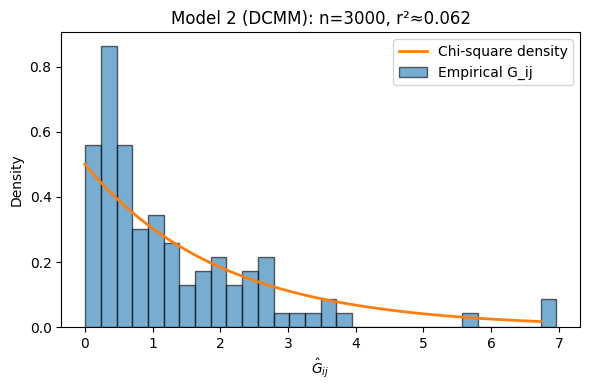

In [127]:
stats_G_3000, r2_3000 = collect_null_G_stats_model2(
    n=3000, n0=500, rho=0.2,
    K=3, n_rep=100, seed=123
)

plot_null_hist_G(
    stats_G_3000, K=3,
    n=3000, r2=r2_3000,
    title_prefix="Model 2 (DCMM)"
)


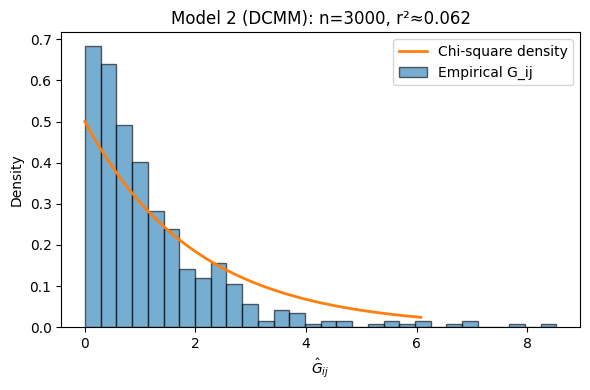

In [ ]:
stats_G_3000, r2_3000 = collect_null_G_stats_model2(
    n=3000, n0=500, rho=0.2,
    K=3, n_rep=500, seed=123
)

plot_null_hist_G(
    stats_G_3000, K=3,
    n=3000, r2=r2_3000,
    title_prefix="Model 2 (DCMM)"
)


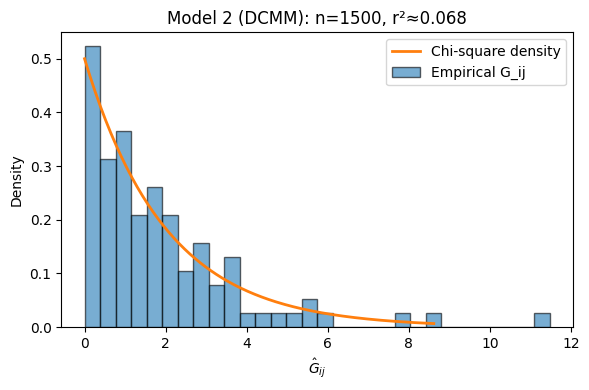

In [129]:
stats_G_1500, r2_1500 = collect_null_G_stats_model2(
    n=1500, n0=300, rho=0.2,
    K=3, n_rep=100, seed=123
)

plot_null_hist_G(
    stats_G_1500, K=3,
    n=1500, r2=r2_1500,
    title_prefix="Model 2 (DCMM)"
)  


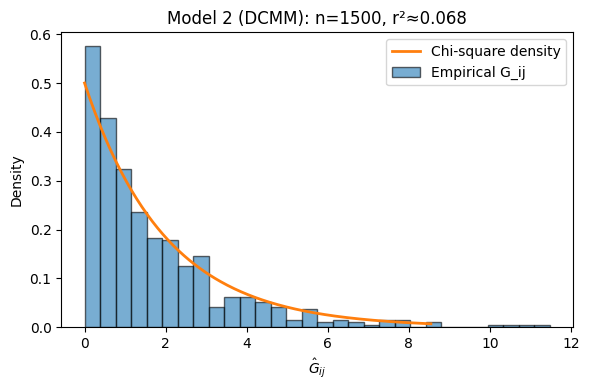

In [125]:
stats_G_1500, r2_1500 = collect_null_G_stats_model2(
    n=1500, n0=300, rho=0.2,
    K=3, n_rep=500, seed=123
)

plot_null_hist_G(
    stats_G_1500, K=3,
    n=1500, r2=r2_1500,
    title_prefix="Model 2 (DCMM)"
)  


Extend squared r and theta beyond the author's grid

In [24]:
def sensitivity_extended_theta_model1(n=1500, n0=300,
                                      theta_grid=None,
                                      rho=0.2, K=3, n_rep=200, alpha=0.05, seed=123):
    if theta_grid is None:
        theta_grid = np.round(np.arange(0.05, 1.25, 0.05), 2)
    return simulate_size_power_model1(
        n=n, n0=n0, rho=rho,
        theta_values=theta_grid, K=K,
        n_rep=n_rep, alpha=alpha, seed=seed
    )

def sensitivity_extended_r2_model2(n=1500, n0=300,
                                   r2_grid=None,
                                   rho=0.2, K=3, n_rep=200, alpha=0.05, seed=123):
    if r2_grid is None:
        r2_grid = np.round(np.arange(0.05, 1.25, 0.05), 2)
    return simulate_size_power_model2(
        n=n, n0=n0, rho=rho,
        r2_values=r2_grid, K=K,
        n_rep=n_rep, alpha=alpha, seed=seed
    )




In [ ]:
res_theta_ext = sensitivity_extended_theta_model1()
res_r2_ext    = sensitivity_extended_r2_model2()
print(pd.DataFrame(res_theta_ext).head())
print(pd.DataFrame(res_r2_ext).head())


[Model1] θ=0.1  size=0.120  power=0.280
[Model1] θ=0.1  size=0.030  power=0.420
[Model1] θ=0.1  size=0.040  power=0.480
[Model1] θ=0.2  size=0.070  power=0.740
[Model1] θ=0.2  size=0.040  power=0.790
[Model1] θ=0.3  size=0.050  power=0.890
[Model1] θ=0.3  size=0.010  power=0.940
[Model1] θ=0.4  size=0.040  power=0.970
[Model1] θ=0.5  size=0.020  power=0.980
[Model1] θ=0.5  size=0.080  power=0.990
[Model1] θ=0.6  size=0.010  power=1.000
[Model1] θ=0.6  size=0.020  power=0.990
[Model1] θ=0.7  size=0.010  power=1.000
[Model1] θ=0.7  size=0.060  power=1.000
[Model1] θ=0.8  size=0.000  power=1.000
[Model1] θ=0.8  size=0.010  power=1.000
[Model1] θ=0.8  size=0.010  power=1.000
[Model1] θ=0.9  size=0.010  power=1.000
[Model1] θ=0.9  size=0.000  power=1.000
[Model1] θ=1.0  size=0.020  power=1.000
[Model1] θ=1.1  size=0.000  power=1.000
[Model1] θ=1.1  size=0.000  power=1.000
[Model1] θ=1.1  size=0.000  power=1.000
[Model1] θ=1.2  size=0.010  power=1.000


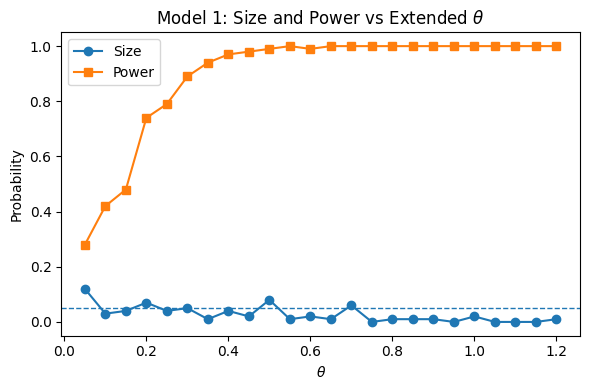

In [ ]:
# Run sensitivity
df_theta_ext = sensitivity_extended_theta_model1(
    n=1500, n0=300,
    theta_grid=None,      # uses default 0.05..1.20
    rho=0.2, K=3,
    n_rep=100, alpha=0.05, seed=123
)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df_theta_ext["theta"], df_theta_ext["size"], marker="o", label="Size")
plt.plot(df_theta_ext["theta"], df_theta_ext["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)  # nominal level
plt.xlabel(r"$\theta$")
plt.ylabel("Probability")
plt.title("Model 1: Size and Power vs Extended $\\theta$")
plt.legend()
plt.tight_layout()
plt.show()


[Model1] θ=0.1  size=0.070  power=0.330
[Model1] θ=0.1  size=0.030  power=0.580
[Model1] θ=0.1  size=0.060  power=0.820
[Model1] θ=0.2  size=0.020  power=0.940
[Model1] θ=0.2  size=0.050  power=0.970
[Model1] θ=0.3  size=0.000  power=0.990
[Model1] θ=0.3  size=0.010  power=0.990
[Model1] θ=0.4  size=0.030  power=0.990
[Model1] θ=0.5  size=0.030  power=1.000
[Model1] θ=0.5  size=0.010  power=1.000
[Model1] θ=0.6  size=0.010  power=1.000
[Model1] θ=0.6  size=0.000  power=1.000
[Model1] θ=0.7  size=0.020  power=1.000
[Model1] θ=0.7  size=0.020  power=1.000
[Model1] θ=0.8  size=0.010  power=1.000
[Model1] θ=0.8  size=0.010  power=1.000
[Model1] θ=0.8  size=0.000  power=1.000
[Model1] θ=0.9  size=0.010  power=1.000
[Model1] θ=0.9  size=0.000  power=1.000
[Model1] θ=1.0  size=0.010  power=1.000
[Model1] θ=1.1  size=0.010  power=1.000
[Model1] θ=1.1  size=0.000  power=1.000
[Model1] θ=1.1  size=0.000  power=1.000
[Model1] θ=1.2  size=0.000  power=1.000


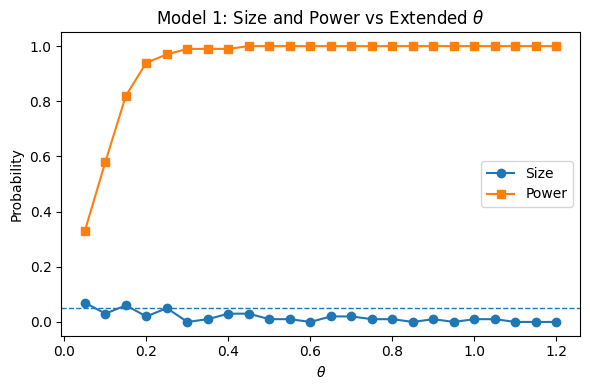

In [ ]:


# Run sensitivity
df_theta_ext = sensitivity_extended_theta_model1(
    n=3000, n0=500,
    theta_grid=None,      # uses default 0.05..1.20
    rho=0.2, K=3,
    n_rep=100, alpha=0.05, seed=123
)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df_theta_ext["theta"], df_theta_ext["size"], marker="o", label="Size")
plt.plot(df_theta_ext["theta"], df_theta_ext["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)  # nominal level
plt.xlabel(r"$\theta$")
plt.ylabel("Probability")
plt.title("Model 1: Size and Power vs Extended $\\theta$")
plt.legend()
plt.tight_layout()
plt.show()


[Model2] r²=0.1  size=0.150  power=0.290
[Model2] r²=0.1  size=0.210  power=0.440
[Model2] r²=0.1  size=0.220  power=0.590
[Model2] r²=0.2  size=0.190  power=0.680
[Model2] r²=0.2  size=0.230  power=0.810
[Model2] r²=0.3  size=0.270  power=0.790
[Model2] r²=0.3  size=0.160  power=0.870
[Model2] r²=0.4  size=0.220  power=0.910
[Model2] r²=0.5  size=0.310  power=0.920
[Model2] r²=0.5  size=0.200  power=0.970
[Model2] r²=0.6  size=0.180  power=0.980
[Model2] r²=0.6  size=0.180  power=0.990
[Model2] r²=0.7  size=0.180  power=1.000
[Model2] r²=0.7  size=0.270  power=1.000
[Model2] r²=0.8  size=0.190  power=1.000
[Model2] r²=0.8  size=0.200  power=1.000
[Model2] r²=0.8  size=0.160  power=1.000
[Model2] r²=0.9  size=0.160  power=1.000
[Model2] r²=0.9  size=0.270  power=1.000
[Model2] r²=1.0  size=0.230  power=1.000
[Model2] r²=1.1  size=0.190  power=1.000
[Model2] r²=1.1  size=0.200  power=1.000
[Model2] r²=1.1  size=0.230  power=1.000
[Model2] r²=1.2  size=0.250  power=1.000


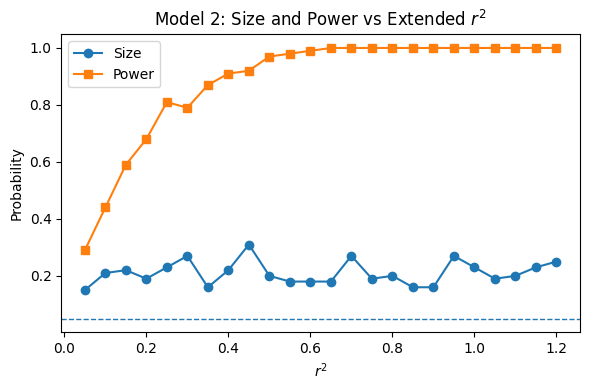

In [19]:
df_r2_ext = sensitivity_extended_r2_model2(
    n=1500, n0=300,
    r2_grid=None,       # default 0.05..1.20
    rho=0.2, K=3,
    n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_r2_ext["r2"], df_r2_ext["size"], marker="o", label="Size")
plt.plot(df_r2_ext["r2"], df_r2_ext["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel(r"$r^2$")
plt.ylabel("Probability")
plt.title("Model 2: Size and Power vs Extended $r^2$")
plt.legend()
plt.tight_layout()
plt.show()


[Model2] r²=0.1  size=0.190  power=0.410
[Model2] r²=0.1  size=0.220  power=0.530
[Model2] r²=0.1  size=0.180  power=0.730
[Model2] r²=0.2  size=0.200  power=0.880
[Model2] r²=0.2  size=0.250  power=0.980
[Model2] r²=0.3  size=0.320  power=0.990
[Model2] r²=0.3  size=0.230  power=0.970
[Model2] r²=0.4  size=0.320  power=0.990
[Model2] r²=0.5  size=0.220  power=0.990
[Model2] r²=0.5  size=0.230  power=0.990
[Model2] r²=0.6  size=0.220  power=1.000
[Model2] r²=0.6  size=0.220  power=1.000
[Model2] r²=0.7  size=0.240  power=1.000
[Model2] r²=0.7  size=0.190  power=1.000
[Model2] r²=0.8  size=0.240  power=1.000
[Model2] r²=0.8  size=0.180  power=1.000
[Model2] r²=0.8  size=0.210  power=1.000
[Model2] r²=0.9  size=0.240  power=1.000
[Model2] r²=0.9  size=0.300  power=1.000
[Model2] r²=1.0  size=0.170  power=1.000
[Model2] r²=1.1  size=0.160  power=1.000
[Model2] r²=1.1  size=0.190  power=1.000
[Model2] r²=1.1  size=0.270  power=1.000
[Model2] r²=1.2  size=0.250  power=1.000


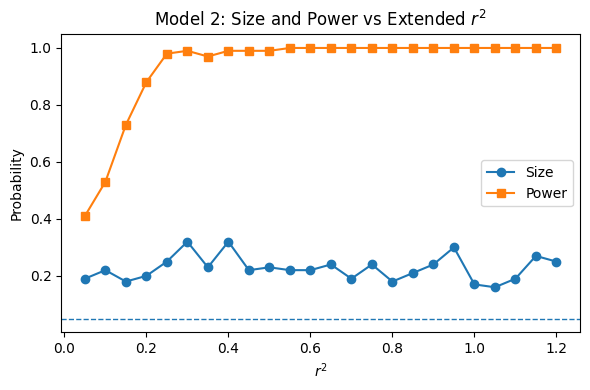

In [18]:
df_r2_ext = sensitivity_extended_r2_model2(
    n=3000, n0=500,
    r2_grid=None,       # default 0.05..1.20
    rho=0.2, K=3,
    n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_r2_ext["r2"], df_r2_ext["size"], marker="o", label="Size")
plt.plot(df_r2_ext["r2"], df_r2_ext["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel(r"$r^2$")
plt.ylabel("Probability")
plt.title("Model 2: Size and Power vs Extended $r^2$")
plt.legend()
plt.tight_layout()
plt.show()


Vary Sparsity or density

In [ ]:


def sensitivity_rho_model1(n=1500, n0=300, theta=0.5,
                           rho_list=None, K=3,
                           n_rep=200, alpha=0.05, seed=123):
    """
    Size/power for Model 1 as rho varies, at fixed theta.
    """
    if rho_list is None:
        rho_list = [0.05, 0.1, 0.2, 0.3]

    rows = []
    for rho in rho_list:
        res = simulate_size_power_model1(
            n=n, n0=n0, rho=rho,
            theta_values=[theta], K=K,
            n_rep=n_rep, alpha=alpha, seed=seed
        )
        rows.append({
            "rho": rho,
            "theta": theta,
            "size": res["size"][0],
            "power": res["power"][0]
        })

    return pd.DataFrame(rows)


def sensitivity_rho_model2(n=1500, n0=300, r2=0.5,
                           rho_list=None, K=3,
                           n_rep=200, alpha=0.05, seed=123):
    """
    Size/power for Model 2 as rho varies, at fixed r^2.
    """
    if rho_list is None:
        rho_list = [0.05, 0.1, 0.2, 0.3]

    rows = []
    for rho in rho_list:
        res = simulate_size_power_model2(
            n=n, n0=n0, rho=rho,
            r2_values=[r2], K=K,
            n_rep=n_rep, alpha=alpha, seed=seed
        )
        rows.append({
            "rho": rho,
            "r2": r2,
            "size": res["size"][0],
            "power": res["power"][0]
        })

    return pd.DataFrame(rows)





[Model1] θ=0.5  size=0.010  power=1.000
[Model1] θ=0.5  size=0.010  power=1.000
[Model1] θ=0.5  size=0.000  power=1.000
[Model1] θ=0.5  size=0.000  power=1.000


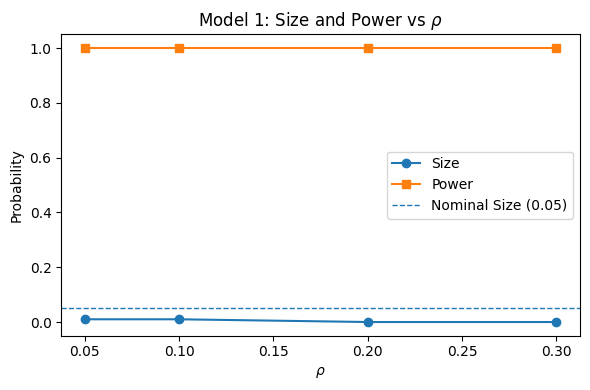

 rho  theta  size  power
0.05    0.5  0.01    1.0
0.10    0.5  0.01    1.0
0.20    0.5  0.00    1.0
0.30    0.5  0.00    1.0


In [ ]:
df_rho_M1 = sensitivity_rho_model1(
    n=3000, n0=500,
    theta=0.5,
    rho_list=[0.05, 0.1, 0.2, 0.3],
    K=3, n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_rho_M1["rho"], df_rho_M1["size"], marker="o", label="Size")
plt.plot(df_rho_M1["rho"], df_rho_M1["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1, label="Nominal Size (0.05)")

plt.xlabel(r"$\rho$")
plt.ylabel("Probability")
plt.title("Model 1: Size and Power vs $\\rho$")
plt.legend()
plt.tight_layout()
plt.show()

print(df_rho_M1.to_string(index=False))


[Model1] θ=0.5  size=0.060  power=1.000
[Model1] θ=0.5  size=0.060  power=1.000
[Model1] θ=0.5  size=0.030  power=0.990
[Model1] θ=0.5  size=0.040  power=0.970


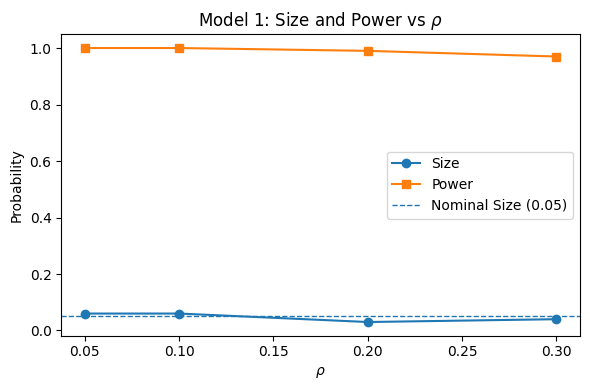

 rho  theta  size  power
0.05    0.5  0.06   1.00
0.10    0.5  0.06   1.00
0.20    0.5  0.03   0.99
0.30    0.5  0.04   0.97


In [ ]:
df_rho_M1 = sensitivity_rho_model1(
    n=1500, n0=300,
    theta=0.5,
    rho_list=[0.05, 0.1, 0.2, 0.3],
    K=3, n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_rho_M1["rho"], df_rho_M1["size"], marker="o", label="Size")
plt.plot(df_rho_M1["rho"], df_rho_M1["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1, label="Nominal Size (0.05)")

plt.xlabel(r"$\rho$")
plt.ylabel("Probability")
plt.title("Model 1: Size and Power vs $\\rho$")
plt.legend()
plt.tight_layout()
plt.show()

print(df_rho_M1.to_string(index=False))


[Model2] r²=0.5  size=0.210  power=1.000
[Model2] r²=0.5  size=0.220  power=1.000
[Model2] r²=0.5  size=0.190  power=0.990
[Model2] r²=0.5  size=0.200  power=0.980


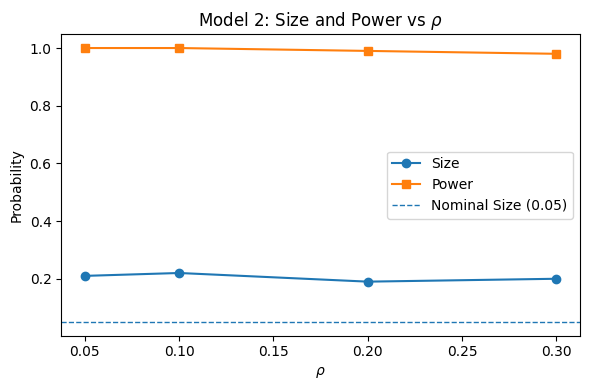

 rho  r2  size  power
0.05 0.5  0.21   1.00
0.10 0.5  0.22   1.00
0.20 0.5  0.19   0.99
0.30 0.5  0.20   0.98


In [ ]:
df_rho_M2 = sensitivity_rho_model2(
    n=3000, n0=500,
    r2=0.5,
    rho_list=[0.05, 0.1, 0.2, 0.3],
    K=3, n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_rho_M2["rho"], df_rho_M2["size"], marker="o", label="Size")
plt.plot(df_rho_M2["rho"], df_rho_M2["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1, label="Nominal Size (0.05)")

plt.xlabel(r"$\rho$")
plt.ylabel("Probability")
plt.title("Model 2: Size and Power vs $\\rho$")
plt.legend()
plt.tight_layout()
plt.show()

print(df_rho_M2.to_string(index=False))


[Model2] r²=0.5  size=0.120  power=1.000
[Model2] r²=0.5  size=0.150  power=1.000
[Model2] r²=0.5  size=0.190  power=0.980
[Model2] r²=0.5  size=0.210  power=0.910


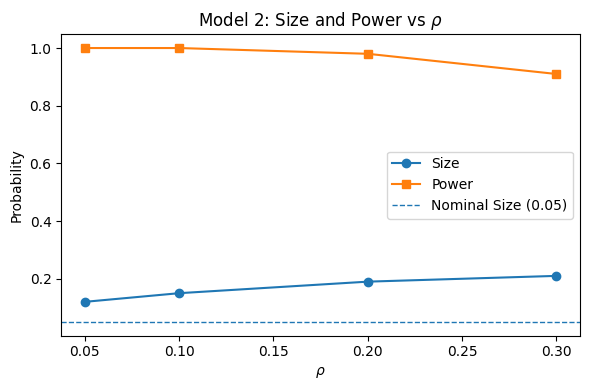

 rho  r2  size  power
0.05 0.5  0.12   1.00
0.10 0.5  0.15   1.00
0.20 0.5  0.19   0.98
0.30 0.5  0.21   0.91


In [ ]:
df_rho_M2 = sensitivity_rho_model2(
    n=1500, n0=300,
    r2=0.5,
    rho_list=[0.05, 0.1, 0.2, 0.3],
    K=3, n_rep=100, alpha=0.05, seed=123
)

plt.figure(figsize=(6,4))
plt.plot(df_rho_M2["rho"], df_rho_M2["size"], marker="o", label="Size")
plt.plot(df_rho_M2["rho"], df_rho_M2["power"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1, label="Nominal Size (0.05)")

plt.xlabel(r"$\rho$")
plt.ylabel("Probability")
plt.title("Model 2: Size and Power vs $\\rho$")
plt.legend()
plt.tight_layout()
plt.show()

print(df_rho_M2.to_string(index=False))


Monte Carlo Variability

In [41]:
def mc_variability_model1(n_rep_list, n=1500, n0=300,
                          theta=0.5, rho=0.2, K=3,
                          alpha=0.05, seed=123):
    rows = []
    for n_rep in n_rep_list:
        res = simulate_size_power_model1(
            n=n, n0=n0, rho=rho,
            theta_values=[theta], K=K,
            n_rep=n_rep, alpha=alpha, seed=seed
        )
        p_size  = res["size"][0]
        p_power = res["power"][0]
        se_size  = np.sqrt(p_size * (1 - p_size) / n_rep)
        se_power = np.sqrt(p_power * (1 - p_power) / n_rep)
        rows.append({
            "n_rep": n_rep,
            "theta": theta,
            "size": p_size,
            "size_SE": se_size,
            "power": p_power,
            "power_SE": se_power
        })
    return pd.DataFrame(rows)

def mc_variability_model2(n_rep_list, n=1500, n0=300,
                          r2=0.5, rho=0.2, K=3,
                          alpha=0.05, seed=123):
    rows = []
    for n_rep in n_rep_list:
        res = simulate_size_power_model2(
            n=n, n0=n0, rho=rho,
            r2_values=[r2], K=K,
            n_rep=n_rep, alpha=alpha, seed=seed
        )
        p_size  = res["size"][0]
        p_power = res["power"][0]
        se_size  = np.sqrt(p_size * (1 - p_size) / n_rep)
        se_power = np.sqrt(p_power * (1 - p_power) / n_rep)
        rows.append({
            "n_rep": n_rep,
            "r2": r2,
            "size": p_size,
            "size_SE": se_size,
            "power": p_power,
            "power_SE": se_power
        })
    return pd.DataFrame(rows)




In [ ]:
df_mc1 = mc_variability_model1([100,200,500,1000])
df_mc2 = mc_variability_model2([100,200,500,1000])
print(df_mc1)
print(df_mc2)


[Model1] θ=0.5  size=0.030  power=0.990
[Model1] θ=0.5  size=0.040  power=0.995
[Model1] θ=0.5  size=0.044  power=0.992
[Model1] θ=0.5  size=0.038  power=0.993
 n_rep  theta  size  size_SE  power  power_SE
   100    0.5 0.030 0.017059  0.990  0.009950
   200    0.5 0.040 0.013856  0.995  0.004987
   500    0.5 0.044 0.009172  0.992  0.003984
  1000    0.5 0.038 0.006046  0.993  0.002636


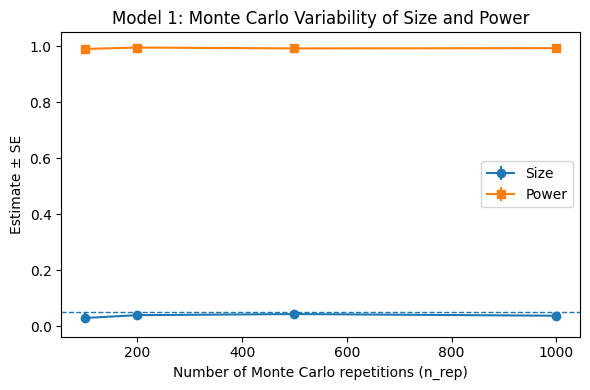

In [43]:
df_mc_M1 = mc_variability_model1(
    n_rep_list=[100, 200, 500, 1000],
    n=1500, n0=300,
    theta=0.5,
    rho=0.2, K=3,
    alpha=0.05, seed=123
)

print(df_mc_M1.to_string(index=False))

plt.figure(figsize=(6,4))
plt.errorbar(df_mc_M1["n_rep"], df_mc_M1["size"],
             yerr=df_mc_M1["size_SE"], marker="o", label="Size")
plt.errorbar(df_mc_M1["n_rep"], df_mc_M1["power"],
             yerr=df_mc_M1["power_SE"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel("Number of Monte Carlo repetitions (n_rep)")
plt.ylabel("Estimate ± SE")
plt.title("Model 1: Monte Carlo Variability of Size and Power")
plt.legend()
plt.tight_layout()
plt.show()


[Model1] θ=0.5  size=0.000  power=1.000
[Model1] θ=0.5  size=0.020  power=1.000
[Model1] θ=0.5  size=0.022  power=1.000
[Model1] θ=0.5  size=0.017  power=1.000
 n_rep  theta  size  size_SE  power  power_SE
   100    0.5 0.000 0.000000    1.0       0.0
   200    0.5 0.020 0.009899    1.0       0.0
   500    0.5 0.022 0.006560    1.0       0.0
  1000    0.5 0.017 0.004088    1.0       0.0


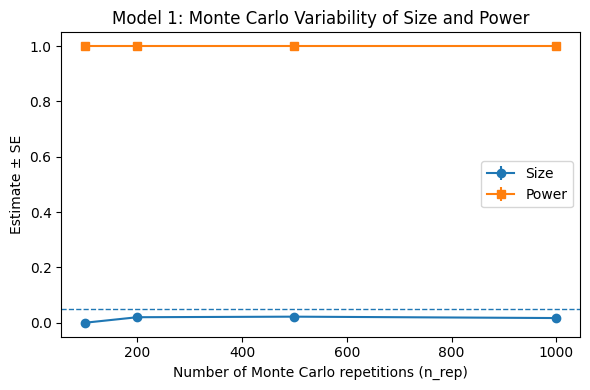

In [42]:
df_mc_M1 = mc_variability_model1(
    n_rep_list=[100, 200, 500, 1000],
    n=3000, n0=500,
    theta=0.5,
    rho=0.2, K=3,
    alpha=0.05, seed=123
)

print(df_mc_M1.to_string(index=False))

plt.figure(figsize=(6,4))
plt.errorbar(df_mc_M1["n_rep"], df_mc_M1["size"],
             yerr=df_mc_M1["size_SE"], marker="o", label="Size")
plt.errorbar(df_mc_M1["n_rep"], df_mc_M1["power"],
             yerr=df_mc_M1["power_SE"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel("Number of Monte Carlo repetitions (n_rep)")
plt.ylabel("Estimate ± SE")
plt.title("Model 1: Monte Carlo Variability of Size and Power")
plt.legend()
plt.tight_layout()
plt.show()


[Model2] r²=0.5  size=0.190  power=0.980
[Model2] r²=0.5  size=0.215  power=0.985
[Model2] r²=0.5  size=0.210  power=0.970
[Model2] r²=0.5  size=0.217  power=0.964
 n_rep  r2  size  size_SE  power  power_SE
   100 0.5 0.190 0.039230  0.980  0.014000
   200 0.5 0.215 0.029050  0.985  0.008595
   500 0.5 0.210 0.018215  0.970  0.007629
  1000 0.5 0.217 0.013035  0.964  0.005891


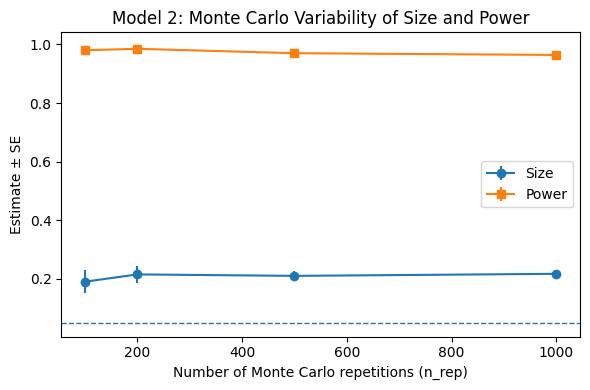

In [44]:
df_mc_M2 = mc_variability_model2(
    n_rep_list=[100, 200, 500, 1000],
    n=1500, n0=300,
    r2=0.5,
    rho=0.2, K=3,
    alpha=0.05, seed=123
)

print(df_mc_M2.to_string(index=False))

plt.figure(figsize=(6,4))
plt.errorbar(df_mc_M2["n_rep"], df_mc_M2["size"],
             yerr=df_mc_M2["size_SE"], marker="o", label="Size")
plt.errorbar(df_mc_M2["n_rep"], df_mc_M2["power"],
             yerr=df_mc_M2["power_SE"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel("Number of Monte Carlo repetitions (n_rep)")
plt.ylabel("Estimate ± SE")
plt.title("Model 2: Monte Carlo Variability of Size and Power")
plt.legend()
plt.tight_layout()
plt.show()


[Model2] r²=0.5  size=0.190  power=0.990
[Model2] r²=0.5  size=0.205  power=0.995
[Model2] r²=0.5  size=0.212  power=0.996
[Model2] r²=0.5  size=0.228  power=0.996
 n_rep  r2  size  size_SE  power  power_SE
   100 0.5 0.190 0.039230  0.990  0.009950
   200 0.5 0.205 0.028546  0.995  0.004987
   500 0.5 0.212 0.018279  0.996  0.002823
  1000 0.5 0.228 0.013267  0.996  0.001996


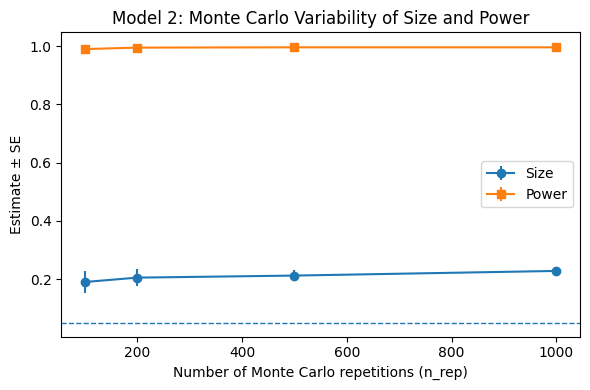

In [45]:
df_mc_M2 = mc_variability_model2(
    n_rep_list=[100, 200, 500, 1000],
    n=3000, n0=500,
    r2=0.5,
    rho=0.2, K=3,
    alpha=0.05, seed=123
)

print(df_mc_M2.to_string(index=False))

plt.figure(figsize=(6,4))
plt.errorbar(df_mc_M2["n_rep"], df_mc_M2["size"],
             yerr=df_mc_M2["size_SE"], marker="o", label="Size")
plt.errorbar(df_mc_M2["n_rep"], df_mc_M2["power"],
             yerr=df_mc_M2["power_SE"], marker="s", label="Power")
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.xlabel("Number of Monte Carlo repetitions (n_rep)")
plt.ylabel("Estimate ± SE")
plt.title("Model 2: Monte Carlo Variability of Size and Power")
plt.legend()
plt.tight_layout()
plt.show()


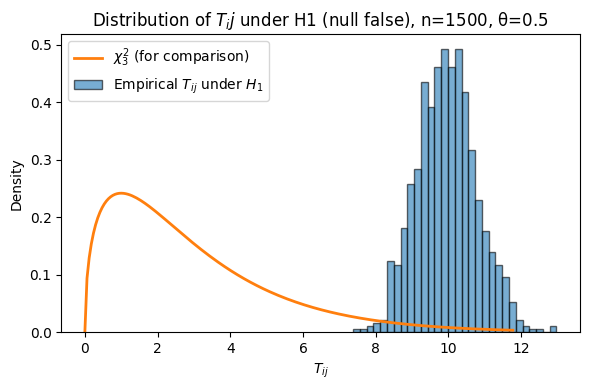

In [ ]:
# ----------------------------
# 1. Memberships and helpers
# ----------------------------

def build_memberships(n=1500, n0=300):
    """
    Simple 3-community structure:
      - first n0 nodes: pure community 1 -> (1,0,0)
      - next  n0 nodes: pure community 2 -> (0,1,0)
      - next  n0 nodes: pure community 3 -> (0,0,1)
      - remaining nodes: balanced mixture (1/3,1/3,1/3)
    """
    K = 3
    Pi = np.zeros((n, K))

    assert 3 * n0 <= n, "n0 too large."
    rem = n - 3 * n0

    Pi[0:n0, :]      = np.array([1, 0, 0])
    Pi[n0:2*n0, :]   = np.array([0, 1, 0])
    Pi[2*n0:3*n0, :] = np.array([0, 0, 1])

    if rem > 0:
        Pi[3*n0:, :] = np.array([1/3, 1/3, 1/3])

    return Pi


def indices_pure_comm1(n0):
    return np.arange(0, n0)          # π = (1,0,0)

def indices_pure_comm2(n0):
    return np.arange(n0, 2*n0)       # π = (0,1,0)

def choose_alt_pair(n, n0, rng=None):
    """
    Choose i in pure community 1 and j in pure community 2.
    This is a scenario where H0: π_i = π_j is FALSE.
    """
    if rng is None:
        rng = np.random.default_rng()

    idx1 = indices_pure_comm1(n0)
    idx2 = indices_pure_comm2(n0)

    i = int(rng.choice(idx1))
    j = int(rng.choice(idx2))
    return i, j


# ----------------------------
# 2. Connectivity and simulator
# ----------------------------

def build_P_model1(theta=0.2):
    """
    Simple P matrix (Model-1 style):
      diag = 1, off-diag = theta.
    """
    return np.array([
        [1.0, theta, theta],
        [theta, 1.0, theta],
        [theta, theta, 1.0]
    ])

def simulate_model1_simple(n=1500, n0=300, theta=0.2, seed=None):
    """
    Simple undirected network:
      X_ij ~ Bernoulli( π_i^T P π_j ).
    """
    if seed is not None:
        np.random.seed(seed)

    Pi = build_memberships(n, n0)
    P = build_P_model1(theta)

    H = Pi @ P @ Pi.T
    H = np.clip(H, 1e-6, 1 - 1e-6)

    X = np.random.binomial(1, H)
    X = np.triu(X, 1)
    X = X + X.T
    np.fill_diagonal(X, 0)

    return X, Pi, P


# ----------------------------
# 3. Spectral embedding and T_ij under H1
# ----------------------------

def spectral_embed_topK(X, K=3):
    """
    Top-K eigenvectors of adjacency matrix X (by |eigenvalue|).
    """
    w, V = np.linalg.eigh(X)
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    d_hat = w[idx_top]
    V_hat = V[:, idx_top]
    return d_hat, V_hat

def Tij_spectral_distance(V_hat, i, j):
    """
    SIMPLE-style test statistic under a very simple covariance:
      T_ij = || sqrt(n) V_i - sqrt(n) V_j ||^2
    """
    n, K = V_hat.shape
    Fi = np.sqrt(n) * V_hat[i, :]
    Fj = np.sqrt(n) * V_hat[j, :]
    diff = Fi - Fj
    return float(diff @ diff)


# ----------------------------
# 4. Monte Carlo: distribution under H1 (null false)
# ----------------------------

def collect_Tij_under_alt(n=1500, n0=300,
                          theta=0.2,
                          K=3, n_rep=1000, seed=123):
    """
    Collect T_ij values when H0 is FALSE:
      i in pure comm 1, j in pure comm 2.
    """
    rng = np.random.default_rng(seed)
    stats = []

    for rep in range(n_rep):
        X, Pi, P = simulate_model1_simple(
            n=n, n0=n0, theta=theta,
            seed=rng.integers(1e9)
        )
        d_hat, V_hat = spectral_embed_topK(X, K)

        i, j = choose_alt_pair(n, n0, rng)  # null false
        T_ij = Tij_spectral_distance(V_hat, i, j)
        stats.append(T_ij)

    return np.array(stats)


# ----------------------------
# 5. Run and plot
# ----------------------------

# Parameters
n = 1500
n0 = 300
theta = 0.5    # moderate community separation
K = 3
n_rep = 1000

# Collect T_ij under H1 (null false)
T_alt = collect_Tij_under_alt(
    n=n, n0=n0,
    theta=theta,
    K=K, n_rep=n_rep, seed=123
)

# Plot histogram of T_ij under alt
xmax = np.percentile(T_alt, 99)  # focus on main mass
x = np.linspace(0, xmax, 200)

plt.figure(figsize=(6,4))
plt.hist(T_alt, bins=30, density=True, alpha=0.6, edgecolor="k")
# optional: overlay a chi-square(3) just for comparison
plt.plot(x, chi2.pdf(x, df=K), linewidth=2)

plt.legend(["$\\chi^2_3$ (for comparison)", "Empirical $T_{ij}$ under $H_1$"])
plt.xlabel(r"$T_{ij}$")
plt.ylabel("Density")
plt.title(f"Distribution of $T_ij$ under H1 (null false), n={n}, θ={theta}")
plt.tight_layout()
plt.show()


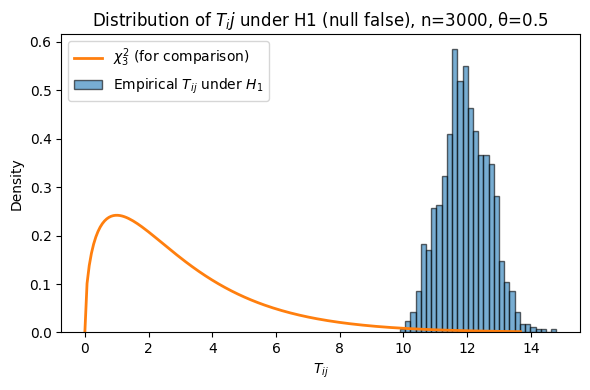

In [ ]:
# ----------------------------
# 5. Run and plot
# ----------------------------

# Parameters
n = 3000
n0 = 500
theta = 0.5    # moderate community separation
K = 3
n_rep = 1000

# Collect T_ij under H1 (null false)
T_alt = collect_Tij_under_alt(
    n=n, n0=n0,
    theta=theta,
    K=K, n_rep=n_rep, seed=123
)

# Plot histogram of T_ij under alt
xmax = np.percentile(T_alt, 99)  # focus on main mass
x = np.linspace(0, xmax, 200)

plt.figure(figsize=(6,4))
plt.hist(T_alt, bins=30, density=True, alpha=0.6, edgecolor="k")
# optional: overlay a chi-square(3) just for comparison
plt.plot(x, chi2.pdf(x, df=K), linewidth=2)

plt.legend(["$\\chi^2_3$ (for comparison)", "Empirical $T_{ij}$ under $H_1$"])
plt.xlabel(r"$T_{ij}$")
plt.ylabel("Density")
plt.title(f"Distribution of $T_ij$ under H1 (null false), n={n}, θ={theta}")
plt.tight_layout()
plt.show()


In [ ]:
# --------------------------------------------------
# 1. Memberships and helper indices
# --------------------------------------------------

def build_memberships_dcmm(n=1500, n0=300):
    """
    Memberships Π for 3 communities, as in the paper:
      - first n0 nodes: pure 1 -> (1,0,0)
      - next  n0 nodes: pure 2 -> (0,1,0)
      - next  n0 nodes: pure 3 -> (0,0,1)
      - remaining nodes: 4 equal mixed groups
          a1 = (0.2, 0.6, 0.2)
          a2 = (0.6, 0.2, 0.2)
          a3 = (0.2, 0.2, 0.6)
          a4 = (1/3, 1/3, 1/3)
    """
    K = 3
    Pi = np.zeros((n, K))

    assert 3 * n0 <= n, "n0 too large for given n."
    rem = n - 3 * n0
    assert rem % 4 == 0, "n - 3*n0 must be divisible by 4."

    # pure nodes
    Pi[0:n0, :]      = np.array([1, 0, 0])
    Pi[n0:2*n0, :]   = np.array([0, 1, 0])
    Pi[2*n0:3*n0, :] = np.array([0, 0, 1])

    # mixed nodes
    a1 = np.array([0.2, 0.6, 0.2])
    a2 = np.array([0.6, 0.2, 0.2])
    a3 = np.array([0.2, 0.2, 0.6])
    a4 = np.array([1/3, 1/3, 1/3])

    m = rem // 4
    start = 3 * n0
    Pi[start:start+m, :]         = a1
    Pi[start+m:start+2*m, :]     = a2
    Pi[start+2*m:start+3*m, :]   = a3
    Pi[start+3*m:start+4*m, :]   = a4

    return Pi

def indices_for_a1_group(n, n0):
    rem = n - 3 * n0
    m = rem // 4
    start = 3 * n0
    end = start + m
    return np.arange(start, end)

def indices_for_pure_comm2(n0):
    return np.arange(n0, 2*n0)

def choose_alt_pair_dcmm(n, n0, rng=None):
    """
    Alternative (null false):
      i from a1 group, j from pure community 2.
    Then π_i != π_j.
    """
    if rng is None:
        rng = np.random.default_rng()

    a1_idx = indices_for_a1_group(n, n0)
    pure2_idx = indices_for_pure_comm2(n0)

    i = int(rng.choice(a1_idx))
    j = int(rng.choice(pure2_idx))
    return i, j

# --------------------------------------------------
# 2. DCMM model pieces
# --------------------------------------------------

def build_P_dcmm(rho=0.2):
    """P with diag=1, off-diagonals=rho."""
    return np.array([
        [1.0, rho, rho],
        [rho, 1.0, rho],
        [rho, rho, 1.0]
    ])

def theta_dcmm(n, r):
    """1/theta_i ~ Uniform(1/r, 2/r)."""
    u = np.random.uniform(1/r, 2/r, size=n)
    return 1.0 / u

def simulate_model2_dcmm(n=1500, n0=300, rho=0.2, r=0.5, seed=None):
    """
    Model 2 DCMM network:
      X_ij ~ Bernoulli( θ_i θ_j π_i^T P π_j ).
    """
    if seed is not None:
        np.random.seed(seed)

    Pi = build_memberships_dcmm(n=n, n0=n0)
    P  = build_P_dcmm(rho=rho)
    theta = theta_dcmm(n, r)

    H_core = Pi @ P @ Pi.T
    H = np.outer(theta, theta) * H_core
    H = np.clip(H, 1e-6, 1 - 1e-6)

    X = np.random.binomial(1, H)
    X = np.triu(X, 1)
    X = X + X.T
    np.fill_diagonal(X, 0)

    return X, Pi, P, theta

# --------------------------------------------------
# 3. Spectral + Y + Σ2 from null nodes
# --------------------------------------------------

def spectral_embed_topK(X, K=3):
    w, V = np.linalg.eigh(X)
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    d_hat = w[idx_top]
    V_hat = V[:, idx_top]
    return d_hat, V_hat

def build_Y_from_V(V_hat):
    """
    Y_i(k-1) = v_k(i)/v_1(i),  k=2,...,K.
    """
    n, K = V_hat.shape
    v1 = V_hat[:, 0]
    eps = 1e-8
    denom = np.where(np.abs(v1) > eps, v1,
                     np.sign(v1) * eps + (v1 == 0)*eps)
    Y = V_hat[:, 1:] / denom[:, None]
    return Y

def estimate_Sigma2_null_only(Y, null_idx, ridge=1e-4):
    """
    Σ2 estimated only from a1-group nodes (null group),
    then inverted with ridge regularization.
    """
    n, q = Y.shape
    F = np.sqrt(n) * Y[null_idx, :]      # (m, q)
    S = np.cov(F.T, bias=False)          # q x q
    S += ridge * np.eye(q)
    S_inv = np.linalg.pinv(S)
    return S_inv

def Gij_whitened(Y, i, j, S2_inv):
    """
    Proper SIMPLE-style G_ij:
      G_ij = (sqrt(n)(Y_i-Y_j))^T Σ2^{-1} sqrt(n)(Y_i-Y_j).
    """
    n, q = Y.shape
    Fi = np.sqrt(n) * Y[i, :]
    Fj = np.sqrt(n) * Y[j, :]
    diff = Fi - Fj
    return float(diff @ S2_inv @ diff)

# --------------------------------------------------
# 4. Collect G_ij under H1 (null false)
# --------------------------------------------------

def collect_Gij_under_H1_dcmm(n=1500, n0=300,
                              rho=0.2, r2=0.5,
                              K=3, n_rep=1000, seed=123):
    """
    Collect G_ij when H0 is FALSE:
      i in a1 group, j in pure community 2.
    Σ2 is re-estimated from null nodes (a1) each replication.
    """
    rng = np.random.default_rng(seed)
    stats = []
    r = float(np.sqrt(r2))

    for rep in range(n_rep):
        # simulate DCMM network
        X, Pi, P, theta = simulate_model2_dcmm(
            n=n, n0=n0, rho=rho, r=r,
            seed=rng.integers(1e9)
        )

        # spectral embedding + ratio features
        d_hat, V_hat = spectral_embed_topK(X, K)
        Y = build_Y_from_V(V_hat)

        # estimate Σ2 from null group (a1)
        a1_idx = indices_for_a1_group(n, n0)
        S2_inv = estimate_Sigma2_null_only(Y, a1_idx, ridge=1e-4)

        # choose (i,j) under H1
        i, j = choose_alt_pair_dcmm(n, n0, rng)  # a1 vs pure comm2
        G_ij = Gij_whitened(Y, i, j, S2_inv)
        stats.append(G_ij)

    return np.array(stats)

# --------------------------------------------------
# 5. Plot G_ij under H1 with chi-square(2) for reference
# --------------------------------------------------

def plot_Gij_H1_dcmm(n=1500, n0=300, rho=0.2, r2=0.5,
                     K=3, n_rep=1000, seed=123):

    G_alt = collect_Gij_under_H1_dcmm(
        n=n, n0=n0, rho=rho, r2=r2,
        K=K, n_rep=n_rep, seed=seed
    )

    xmax = np.percentile(G_alt, 99)  # only for chi-square overlay
    x = np.linspace(0, xmax, 200)

    plt.figure(figsize=(6,4))

    # Histogram
    plt.hist(G_alt, bins=30, density=True, alpha=0.6, edgecolor="k",
             label="Empirical $G_{ij}$ under $H_1$")

    # Chi-square reference
    plt.plot(x, chi2.pdf(x, df=K-1), linewidth=2,
             label="$\\chi^2_2$ (for comparison)")

    # ✅ Force x-axis to only the region where data lives
    plt.xlim(0, 50)

    plt.xlabel(r"$G_{ij}$")
    plt.ylabel("Density")
    plt.title(
        f"Model 2: $G_{{ij}}$ under $H_1$ (a1 vs pure comm2), n={n}, r^2={r2}"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_Gij_H1_dcmm_pretty(n=1500, n0=300, rho=0.2, r2=0.5,
                            K=3, n_rep=1000, seed=123):
    # 1. collect G_ij under H1 (a1 vs pure comm2)
    G_alt = collect_Gij_under_H1_dcmm(
        n=n, n0=n0, rho=rho, r2=r2,
        K=K, n_rep=n_rep, seed=seed
    )

    # 2. choose a tight x-range around the main mass, like for Tij
    x_low  = np.percentile(G_alt, 0.5)
    x_high = np.percentile(G_alt, 99.5)

    x = np.linspace(0, x_high, 400)

    # 3. make the plot in the same style as your Tij figure
    plt.figure(figsize=(6,4))

    # histogram (many narrow bins, concentrated in [x_low, x_high])
    plt.hist(
        G_alt,
        bins=40,
        range=(x_low, x_high),
        density=True,
        alpha=0.6,
        edgecolor="k",
        label="Empirical $G_{ij}$ under $H_1$"
    )

    # chi-square_2 density for comparison
    plt.plot(
        x,
        chi2.pdf(x, df=K-1),
        linewidth=2,
        label="$\\chi^2_2$ (for comparison)"
    )

    plt.xlabel(r"$G_{ij}$")
    plt.ylabel("Density")
    plt.title(
        rf"Distribution of $G_{{ij}}$ under $H_1$, "
        rf"n={n}, r^2={r2}"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


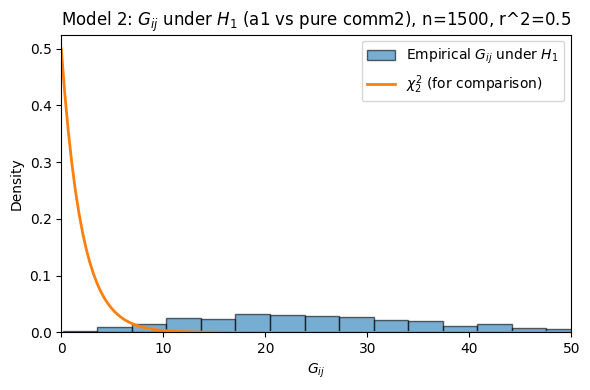

In [52]:
plot_Gij_H1_dcmm(n=1500, n0=300, rho=0.2, r2=0.5,
                K=3, n_rep=1000, seed=123)

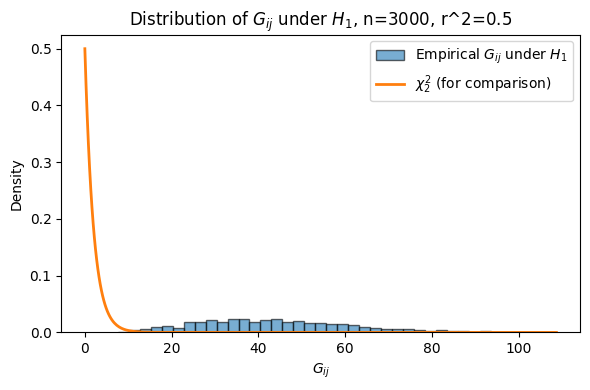

In [55]:
plot_Gij_H1_dcmm_pretty(n=3000, n0=500, rho=0.2, r2=0.5,
                        K=3, n_rep=1000, seed=123)
